In [42]:
# !pip install v3io_frames
# !pip install dask distributed
# !pip install 'bokeh==0.13.0'

import os

# Dataframes
import v3io_frames as v3f
import dask.dataframe as dd
from dask.distributed import Client, progress
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt; plt.rcdefaults()
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column, row, gridplot
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral11
import seaborn as sns; sns.set()


output_notebook()
%matplotlib inline

Loading BokehJS ...

In [43]:
dask_client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
dask_client

/User/.pythonlibs/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:34453 Dashboard: http://127.0.0.1:41341/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


## Load data
Using the time-series DB

In [45]:
client = v3f.Client('framesd-h7a26fh1yk-ncymt:8081', token=os.environ['V3IO_ACCESS_KEY'])
df = dd.from_pandas(client.read(backend='tsdb', query='select * from netops_metrics_jupyter',
            start="now-2d", end='now+1d', multi_index=True).reset_index(), npartitions=4)
df.head(5)

/User/.pythonlibs/lib/python3.6/site-packages/v3io_frames/pdutils.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ignore_index=True,


,time,company,data_center,device,cpu_utilization,cpu_utilization_is_error,is_error,latency,latency_is_error,packet_loss,packet_loss_is_error,throughput,throughput_is_error
0,2019-02-20 14:50:56.303,Ingram_LLC,Evans_Lane,3838035706969,65.27,0.0,0.0,1.65,0.0,0.0,0.0,232.47,0.0
1,2019-02-20 14:51:02.303,Ingram_LLC,Evans_Lane,3838035706969,67.09,0.0,0.0,4.10,0.0,0.0,0.0,227.66,0.0
2,2019-02-20 14:51:08.303,Ingram_LLC,Evans_Lane,3838035706969,61.04,0.0,0.0,0.38,0.0,0.0,0.0,242.31,0.0
3,2019-02-20 14:51:14.303,Ingram_LLC,Evans_Lane,3838035706969,62.56,0.0,0.0,0.00,0.0,0.0,0.0,248.33,0.0
4,2019-02-20 14:51:20.303,Ingram_LLC,Evans_Lane,3838035706969,66.14,0.0,0.0,0.07,0.0,1.0,0.0,240.79,0.0


Reading as CSV file and processing in parallel with Dask

## Sample device

In [47]:
sample_device = df[(df['company'] == 'Ingram_LLC') & (df['data_center'] == 'Evans_Lane') & (df['device'] == '3838035706969')]
sample_device.head(10)

,time,company,data_center,device,cpu_utilization,cpu_utilization_is_error,is_error,latency,latency_is_error,packet_loss,packet_loss_is_error,throughput,throughput_is_error
0,2019-02-20 14:50:56.303,Ingram_LLC,Evans_Lane,3838035706969,65.27,0.0,0.0,1.65,0.0,0.0,0.0,232.47,0.0
1,2019-02-20 14:51:02.303,Ingram_LLC,Evans_Lane,3838035706969,67.09,0.0,0.0,4.10,0.0,0.0,0.0,227.66,0.0
2,2019-02-20 14:51:08.303,Ingram_LLC,Evans_Lane,3838035706969,61.04,0.0,0.0,0.38,0.0,0.0,0.0,242.31,0.0
3,2019-02-20 14:51:14.303,Ingram_LLC,Evans_Lane,3838035706969,62.56,0.0,0.0,0.00,0.0,0.0,0.0,248.33,0.0
4,2019-02-20 14:51:20.303,Ingram_LLC,Evans_Lane,3838035706969,66.14,0.0,0.0,0.07,0.0,1.0,0.0,240.79,0.0
5,2019-02-20 14:51:26.303,Ingram_LLC,Evans_Lane,3838035706969,69.82,0.0,0.0,10.46,0.0,0.0,0.0,237.56,0.0
6,2019-02-20 14:51:32.303,Ingram_LLC,Evans_Lane,3838035706969,64.17,0.0,0.0,0.00,0.0,2.0,0.0,257.27,0.0
7,2019-02-20 14:51:38.303,Ingram_LLC,Evans_Lane,3838035706969,70.08,0.0,0.0,0.00,0.0,0.0,0.0,264.08,0.0
8,2019-02-20 14:51:44.303,Ingram_LLC,Evans_Lane,3838035706969,58.85,0.0,0.0,0.00,0.0,0.0,0.0,217.16,0.0
9,2019-02-20 14:51:50.303,Ingram_LLC,Evans_Lane,3838035706969,75.83,0.0,0.0,0.00,0.0,0.0,0.0,233.58,0.0


### Metrics

In [48]:
sample_component_performance = sample_device['cpu_utilization'].compute()
p = figure(title="Sample Performance Generation [ CPU Utilization ]",
            x_axis_label="ticks",
            y_axis_label="CPU Utilization (%)",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Utilization (%)")
show(p)
print(sample_component_performance.describe())

count    1000.000000
mean       70.845860
std        11.369051
min        39.830000
25%        63.205000
50%        70.675000
75%        77.752500
max       100.000000
Name: cpu_utilization, dtype: float64


In [49]:
sample_component_performance = sample_device['latency'].compute()
p = figure(title="Sample Performance Generation [ Latency ]",
            x_axis_label="ticks",
            y_axis_label="Latency (ms)",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Latency (ms)")
show(p)
print(sample_component_performance.describe())

count    1000.000000
mean        4.253630
std        15.262356
min         0.000000
25%         0.000000
50%         0.315000
75%         3.522500
max       100.000000
Name: latency, dtype: float64


In [50]:
sample_component_performance = sample_device['packet_loss'].compute()
p = figure(title="Sample Performance Generation [ Packet loss ]",
            x_axis_label="ticks",
            y_axis_label="Packet loss",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Packet loss")
show(p)
print(sample_component_performance.describe())

count    1000.00000
mean        1.92000
std         7.31937
min         0.00000
25%         0.00000
50%         0.00000
75%         2.00000
max        50.00000
Name: packet_loss, dtype: float64


In [51]:
sample_component_performance = sample_device['throughput'].compute()
p = figure(title="Sample Performance Generation [ Throughput ]",
            x_axis_label="ticks",
            y_axis_label="Throughput",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance, 
    legend="Throughput")
show(p)
print(sample_component_performance.describe())

count    1000.000000
mean      245.423340
std        38.282523
min         0.000000
25%       237.215000
50%       249.885000
75%       263.140000
max       300.000000
Name: throughput, dtype: float64


In [52]:
sample_component_performance = sample_device['is_error'].compute()
p = figure(title="Sample Performance Generation [ All + Error ]",
            x_axis_label="ticks",
            y_axis_label="Metrics",
            width=1200)
p.line(x=range(len(sample_component_performance)), 
    y=sample_component_performance-5, 
    legend="Error",
    color='red')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['cpu_utilization'].compute(), 
    legend="cpu_utilization",
    color='blue')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['latency'].compute(), 
    legend="latency",
    color='green')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['throughput'].compute(), 
    legend="throughput",
    color='black')
p.line(x=range(len(sample_component_performance)), 
    y=sample_device['packet_loss'].compute(), 
    legend="packet_loss",
    color='orange')
show(p)

### Correlations

In [53]:
X = df.compute()
correlations = X[['cpu_utilization', 'latency', 'throughput', 'packet_loss', 'is_error']].corr()
correlations

,cpu_utilization,latency,throughput,packet_loss,is_error
cpu_utilization,1.000000,0.583826,-0.517928,0.567193,0.543071
latency,0.583826,1.000000,-0.739282,0.814194,0.794756
throughput,-0.517928,-0.739282,1.000000,-0.788669,-0.877884
packet_loss,0.567193,0.814194,-0.788669,1.000000,0.864913
is_error,0.543071,0.794756,-0.877884,0.864913,1.000000


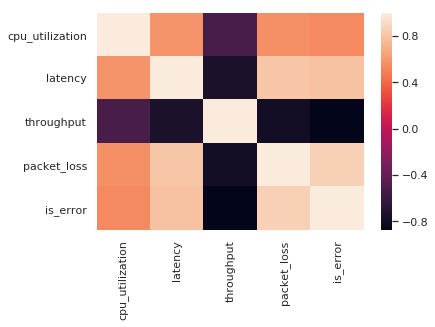

In [54]:
sns.heatmap(correlations)